Same as ribo-DR.ipynb, this notebook collects normalized DR for all samples in TEMPOmap dataset. 

In [1]:
import scanpy as sc
from starmap.sequencing import * # bases 
import pickle
from copy import copy, deepcopy
from tqdm import tqdm
from time import time
import os

import numpy as np
import pandas as pd
from scipy.ndimage import distance_transform_edt as dt
from skimage import measure
from scipy.stats import *
import phate
import scprep

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import plotly.express as px

from spatial_funcs import *

# Input

In [2]:
fpath = '/Users/wangk/Desktop/TEMPOmap/2021-07-16-Rena-Hela-EU-3D-segmentation'
sample_list = ['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash', '1h_labeling_4h_wash', '1h_labeling_6h_wash', '20h_labeling']
adata_all = sc.read_h5ad(os.path.join(fpath, '2021-10-06-Rena-EU-starmap-cc.h5ad'))
adata_si = sc.read_h5ad(os.path.join(fpath, '2021-09-24-Rena-EU-starmap-raw-KD-combined.h5ad'))
adata_all.obs['KD_label_combined'] = adata_si.obs['KD_label_combined']
genes = adata_all.var.index
genesToIndex = genes_to_index(genes)
batchCorr_genes = ['METTL14', 'METTL3', 'YTHDC2', 'YTHDF1', 'YTHDF2', 'YTHDF3'] # for batch correction
starmap_genes = ['METTL14', 'METTL3', 'YTHDC2', 'YTHDF1', 'YTHDF2', 'YTHDF3', 'YTHDC1'] 

## avgDR => NaN for 0 in X (when a gene has no reads in a cell)

In [3]:
rpath = '/Users/wangk/Desktop/TEMPOmap/results/DR1/'
avg_DR = dict()
for sample in sample_list:
    adata = separate_adata_by_sample(adata_all, [sample])
    dr = np.load(rpath+sample+'_DR.npy', allow_pickle=True)
    avg_dr = np.zeros(dr.shape)
    for i in range(dr.shape[0]):
        for j in range(dr.shape[1]):
            if type(dr[i,j]) == list:
                avg_dr[i,j] = np.average(dr[i,j])
            else: avg_dr[i,j] = np.nan 
    adata.layers['avg_DR'] = avg_dr
    avg_DR[sample] = adata

<AxesSubplot:ylabel='Count'>

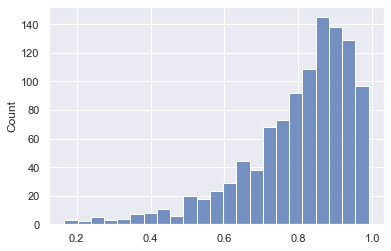

In [4]:
### Dec01
sns.set_theme()
g, s = 'SSR2', '20h_labeling'
ind = list(avg_DR[s].var.index).index(g)
# sns.histplot(avg_DR[s].layers['avg_DR'][:,ind])
sns.histplot(avg_DR[s].layers['avg_DR'][avg_DR[s].obs['KD_label_combined']=='siControl',ind])

In [5]:
df_dict = dict()
for sample in sample_list:
    l = []
    for gene in genes:
        # l.append(np.nanmean(avg_DR[sample].layers['avg_DR'][:,genesToIndex[gene]]))
        if gene not in starmap_genes: # these two lines excludes starmap-probed genes and non-control cells
            l.append([gene, np.nanmean(avg_DR[sample].layers['avg_DR'][avg_DR[sample].obs['KD_label_combined']=='siControl', genesToIndex[gene]])])
    df = pd.DataFrame(l, columns=['gene','avgDR'])
    df['sample'] = sample
    df_dict[sample] = df
df_sns = pd.concat([df_dict[d] for d in sample_list])
df_sns

,gene,avgDR,sample
0,AARS,0.816726,1h_labeling
1,ASXL1,0.772439,1h_labeling
2,COX7B,0.833775,1h_labeling
3,CTGF,0.660071,1h_labeling
4,DLX4,0.786510,1h_labeling
...,...,...,...
986,ZRANB1,0.819359,20h_labeling
987,ZSCAN12,0.812705,20h_labeling
988,ZSCAN29,0.807513,20h_labeling
989,ZXDC,0.803245,20h_labeling


In [13]:
## separating G1, S, G2M
df_cc = dict()
for sample in sample_list:
    l = []
    for gene in genes:
        if gene not in starmap_genes:
            G1 = np.nanmean(avg_DR[sample].layers['avg_DR'][np.logical_and(avg_DR[sample].obs['KD_label_combined']=='siControl', avg_DR[sample].obs['phase_ref']=='G1'), genesToIndex[gene]])
            S = np.nanmean(avg_DR[sample].layers['avg_DR'][np.logical_and(avg_DR[sample].obs['KD_label_combined']=='siControl', avg_DR[sample].obs['phase_ref']=='S'), genesToIndex[gene]])
            G2M = np.nanmean(avg_DR[sample].layers['avg_DR'][np.logical_and(avg_DR[sample].obs['KD_label_combined']=='siControl', avg_DR[sample].obs['phase_ref']=='G2M'), genesToIndex[gene]])
            l.append([gene, G1, S, G2M])
    df = pd.DataFrame(l, columns=['gene','avgDR_G1', 'avgDR_S', 'avgDR_G2M'])
    df['sample'] = sample
    df_cc[sample] = df
df_cc_sns = pd.concat([df_cc[d] for d in sample_list])
df_cc_5 = df_cc_sns[df_cc_sns['sample']!='20h_labeling']

In [14]:
df_cc_5

,gene,avgDR_G1,avgDR_S,avgDR_G2M,sample
0,AARS,0.806723,0.828210,0.811180,1h_labeling
1,ASXL1,0.774168,0.789690,0.757569,1h_labeling
2,COX7B,0.847429,0.833211,0.827611,1h_labeling
3,CTGF,0.662066,0.664633,0.654661,1h_labeling
4,DLX4,0.742896,0.828682,0.774089,1h_labeling
...,...,...,...,...,...
986,ZRANB1,0.835144,0.826299,0.846654,1h_labeling_6h_wash
987,ZSCAN12,0.776811,0.870892,0.868834,1h_labeling_6h_wash
988,ZSCAN29,0.846041,0.828635,0.798792,1h_labeling_6h_wash
989,ZXDC,0.834600,0.794499,0.824874,1h_labeling_6h_wash


In [6]:
## separating G1, S, G2M fist, and further separate into small and large
df_cc_size = dict()
for sample in sample_list[:-1]:
    sample_dr = avg_DR[sample].layers['avg_DR']
    sample_obs = avg_DR[sample].obs
    l = []
    for gene in genes:
        if gene not in starmap_genes:
            g1 = sample_dr[np.logical_and(sample_obs['KD_label_combined']=='siControl', sample_obs['phase_ref']=='G1')]
            g1_obs = sample_obs[np.logical_and(sample_obs['KD_label_combined']=='siControl', sample_obs['phase_ref']=='G1')]
            g1_median = np.median(g1_obs['volume'])
            g1_small = np.nanmean(g1[g1_obs['volume']<g1_median, genesToIndex[gene]])
            g1_large = np.nanmean(g1[g1_obs['volume']>=g1_median, genesToIndex[gene]])
            s = sample_dr[np.logical_and(sample_obs['KD_label_combined']=='siControl', sample_obs['phase_ref']=='S')]
            s_obs = sample_obs[np.logical_and(sample_obs['KD_label_combined']=='siControl', sample_obs['phase_ref']=='S')]
            s_median = np.median(s_obs['volume'])
            s_small = np.nanmean(s[s_obs['volume']<s_median, genesToIndex[gene]])
            s_large = np.nanmean(s[s_obs['volume']>=s_median, genesToIndex[gene]])
            g2m = sample_dr[np.logical_and(sample_obs['KD_label_combined']=='siControl', sample_obs['phase_ref']=='G2M')]
            g2m_obs = sample_obs[np.logical_and(sample_obs['KD_label_combined']=='siControl', sample_obs['phase_ref']=='G2M')]
            g2m_median = np.median(g2m_obs['volume'])
            g2m_small = np.nanmean(g2m[g2m_obs['volume']<g2m_median, genesToIndex[gene]])
            g2m_large = np.nanmean(g2m[g2m_obs['volume']>=g2m_median, genesToIndex[gene]])
            l.append([gene, g1_small, g1_large, s_small, s_large, g2m_small, g2m_large])
    df = pd.DataFrame(l, columns=['gene', 'avgDR_G1_small', 'avgDR_G1_large', 'avgDR_S_small', 'avgDR_S_large', 'avgDR_G2M_small', 'avgDR_G2M_large'])
    df['sample'] = sample
    df_cc_size[sample] = df
df_cc_size = pd.concat([df_cc_size[d] for d in sample_list[:-1]])
df_cc_size

/var/folders/sc/ppvhr05914nfz38dhrrq0vy40000gp/T/ipykernel_36055/2603184573.py:22: RuntimeWarning: Mean of empty slice
  g2m_small = np.nanmean(g2m[g2m_obs['volume']<g2m_median, genesToIndex[gene]])
/var/folders/sc/ppvhr05914nfz38dhrrq0vy40000gp/T/ipykernel_36055/2603184573.py:12: RuntimeWarning: Mean of empty slice
  g1_small = np.nanmean(g1[g1_obs['volume']<g1_median, genesToIndex[gene]])
/var/folders/sc/ppvhr05914nfz38dhrrq0vy40000gp/T/ipykernel_36055/2603184573.py:13: RuntimeWarning: Mean of empty slice
  g1_large = np.nanmean(g1[g1_obs['volume']>=g1_median, genesToIndex[gene]])
/var/folders/sc/ppvhr05914nfz38dhrrq0vy40000gp/T/ipykernel_36055/2603184573.py:17: RuntimeWarning: Mean of empty slice
  s_small = np.nanmean(s[s_obs['volume']<s_median, genesToIndex[gene]])


,gene,avgDR_G1_small,avgDR_G1_large,avgDR_S_small,avgDR_S_large,avgDR_G2M_small,avgDR_G2M_large,sample
0,AARS,0.842689,0.781120,0.783440,0.859059,0.797750,0.818701,1h_labeling
1,ASXL1,0.795807,0.759435,0.806581,0.774653,0.757976,0.757301,1h_labeling
2,COX7B,0.846642,0.847990,0.827518,0.837867,0.827713,0.827543,1h_labeling
3,CTGF,0.658680,0.665093,0.671586,0.658591,0.671682,0.640398,1h_labeling
4,DLX4,0.809569,0.642885,0.793130,0.953115,0.923882,0.729151,1h_labeling
...,...,...,...,...,...,...,...,...
986,ZRANB1,0.836612,0.834454,0.824376,0.827467,0.842738,0.849523,1h_labeling_6h_wash
987,ZSCAN12,0.432286,0.845716,0.827715,0.902294,0.944478,0.844946,1h_labeling_6h_wash
988,ZSCAN29,0.740876,0.913647,0.846506,0.819369,0.734857,0.858319,1h_labeling_6h_wash
989,ZXDC,0.856804,0.824608,0.771801,0.810261,0.849877,0.808762,1h_labeling_6h_wash


In [7]:
sample_col = ['#F8766D', '#A3A500', '#00BF7D', '#00B0F6', '#E76BF3', '#888888']

((array([0, 1, 2, 3, 4, 5]),
  [Text(0, 0, '1h_labeling'),
   Text(1, 0, '1h_labeling_1h_wash'),
   Text(2, 0, '1h_labeling_2h_wash'),
   Text(3, 0, '1h_labeling_4h_wash'),
   Text(4, 0, '1h_labeling_6h_wash'),
   Text(5, 0, '20h_labeling')]),
 Text(0.5, 0, ''))

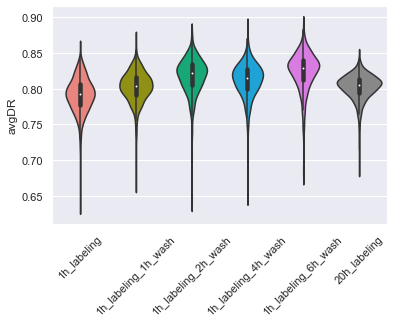

In [8]:
sns.violinplot(data=df_sns, y='avgDR', x='sample', palette=sample_col)
plt.xticks(rotation=45), plt.xlabel(None)

In [9]:
timePoints = {'1h_labeling': 0, '1h_labeling_1h_wash': 1, '1h_labeling_2h_wash': 2, 
    '1h_labeling_4h_wash': 4, '1h_labeling_6h_wash': 6, '20h_labeling': -1}
timePoints

{'1h_labeling': 0,
 '1h_labeling_1h_wash': 1,
 '1h_labeling_2h_wash': 2,
 '1h_labeling_4h_wash': 4,
 '1h_labeling_6h_wash': 6,
 '20h_labeling': -1}

In [10]:
# convert sample to numerical value
time_points = []
for i in range(df_sns.shape[0]):
    time_points.append(timePoints[df_sns.iloc[i]['sample']])
df_sns['time_points'] = time_points
col = [sample_col[sample_list.index(sample)] for sample in df_sns['sample']]
df_sns['color'] = col

In [11]:
df_sns_5 = df_sns[df_sns['time_points']!=-1]
df_sns_5

,gene,avgDR,sample,time_points,color
0,AARS,0.816726,1h_labeling,0,#F8766D
1,ASXL1,0.772439,1h_labeling,0,#F8766D
2,COX7B,0.833775,1h_labeling,0,#F8766D
3,CTGF,0.660071,1h_labeling,0,#F8766D
4,DLX4,0.786510,1h_labeling,0,#F8766D
...,...,...,...,...,...
986,ZRANB1,0.836726,1h_labeling_6h_wash,6,#E76BF3
987,ZSCAN12,0.849813,1h_labeling_6h_wash,6,#E76BF3
988,ZSCAN29,0.818045,1h_labeling_6h_wash,6,#E76BF3
989,ZXDC,0.815296,1h_labeling_6h_wash,6,#E76BF3


In [15]:
df_cc_5['time_points'] = df_sns_5['time_points']
df_cc_5

/var/folders/sc/ppvhr05914nfz38dhrrq0vy40000gp/T/ipykernel_36055/2348925711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_5['time_points'] = df_sns_5['time_points']


,gene,avgDR_G1,avgDR_S,avgDR_G2M,sample,time_points
0,AARS,0.806723,0.828210,0.811180,1h_labeling,0
1,ASXL1,0.774168,0.789690,0.757569,1h_labeling,0
2,COX7B,0.847429,0.833211,0.827611,1h_labeling,0
3,CTGF,0.662066,0.664633,0.654661,1h_labeling,0
4,DLX4,0.742896,0.828682,0.774089,1h_labeling,0
...,...,...,...,...,...,...
986,ZRANB1,0.835144,0.826299,0.846654,1h_labeling_6h_wash,6
987,ZSCAN12,0.776811,0.870892,0.868834,1h_labeling_6h_wash,6
988,ZSCAN29,0.846041,0.828635,0.798792,1h_labeling_6h_wash,6
989,ZXDC,0.834600,0.794499,0.824874,1h_labeling_6h_wash,6


In [16]:
df_cc_size['time_points'] = df_cc_5['time_points']
df_cc_size

,gene,avgDR_G1_small,avgDR_G1_large,avgDR_S_small,avgDR_S_large,avgDR_G2M_small,avgDR_G2M_large,sample,time_points
0,AARS,0.842689,0.781120,0.783440,0.859059,0.797750,0.818701,1h_labeling,0
1,ASXL1,0.795807,0.759435,0.806581,0.774653,0.757976,0.757301,1h_labeling,0
2,COX7B,0.846642,0.847990,0.827518,0.837867,0.827713,0.827543,1h_labeling,0
3,CTGF,0.658680,0.665093,0.671586,0.658591,0.671682,0.640398,1h_labeling,0
4,DLX4,0.809569,0.642885,0.793130,0.953115,0.923882,0.729151,1h_labeling,0
...,...,...,...,...,...,...,...,...,...
986,ZRANB1,0.836612,0.834454,0.824376,0.827467,0.842738,0.849523,1h_labeling_6h_wash,6
987,ZSCAN12,0.432286,0.845716,0.827715,0.902294,0.944478,0.844946,1h_labeling_6h_wash,6
988,ZSCAN29,0.740876,0.913647,0.846506,0.819369,0.734857,0.858319,1h_labeling_6h_wash,6
989,ZXDC,0.856804,0.824608,0.771801,0.810261,0.849877,0.808762,1h_labeling_6h_wash,6


In [17]:
avgDR_list = ['avgDR_G1', 'avgDR_S', 'avgDR_G2M']
temp_dict = dict()
for a in avgDR_list:
    temp = df_cc_5[['gene', a, 'time_points']]
    temp = temp.rename(columns={a:'avgDR'})
    temp['cc'] = a
    temp_dict[a] = temp
df_cc_sns = pd.concat(temp_dict.values())

In [18]:
samcol = dict()
for i, scol in enumerate(sample_list):
    samcol[timePoints[scol]] = sample_col[i]
samcol

{0: '#F8766D',
 1: '#A3A500',
 2: '#00BF7D',
 4: '#00B0F6',
 6: '#E76BF3',
 -1: '#888888'}

## regression

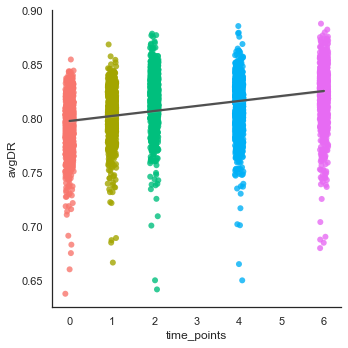

In [19]:
# regression
sns.set_theme(style='white')
sns.lmplot(data=df_sns_5, x='time_points', y='avgDR', x_jitter=0.1, 
            scatter_kws={'facecolor': df_sns_5['color'], 'linewidth':0},
            line_kws={'color':'#505050'})
# sns.lmplot(data=df_sns, x='time_points', y='avgDR', x_jitter=0.1, palette=sample_col, hue='time_points', fit_reg=True)
# plt.xticks(rotation=45)
sns.set_theme()

### regression - single cell

In [20]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

In [21]:
# fit all genes into LR
LR = []
for gene in genes:
    if gene not in starmap_genes:
        X = df_sns_5[df_sns_5['gene']==gene]['time_points']
        y = df_sns_5[df_sns_5['gene']==gene]['avgDR']
        result = linregress(X, y)
        LR.append([gene, result.slope, result.rvalue, result.rvalue**2])
LR_df = pd.DataFrame(LR, columns=['gene', 'slope', 'r', 'r^2'])
LR_df.to_excel('TEMPO-regression.xlsx')
LR_df

,gene,slope,r,r^2
0,AARS,0.004027,0.546613,0.298785
1,ASXL1,0.006390,0.837259,0.701003
2,COX7B,0.001530,0.527489,0.278245
3,CTGF,0.003913,0.501477,0.251480
4,DLX4,0.014314,0.751475,0.564714
...,...,...,...,...
986,ZRANB1,0.001059,0.302416,0.091455
987,ZSCAN12,0.011167,0.943535,0.890257
988,ZSCAN29,0.004557,0.696961,0.485755
989,ZXDC,0.005913,0.917416,0.841653


In [22]:
#  cell cycle+ cell size
LRcs = []
X = [0,1,2,4,6]
for gene in genes:
    if gene not in starmap_genes:
        y_G1_small = df_cc_size[df_cc_size['gene']==gene]['avgDR_G1_small']
        y_S_small = df_cc_size[df_cc_size['gene']==gene]['avgDR_S_small']
        y_G2M_small = df_cc_size[df_cc_size['gene']==gene]['avgDR_G2M_small']
        y_G1_large = df_cc_size[df_cc_size['gene']==gene]['avgDR_G1_large']
        y_S_large = df_cc_size[df_cc_size['gene']==gene]['avgDR_S_large']
        y_G2M_large = df_cc_size[df_cc_size['gene']==gene]['avgDR_G2M_large']
        r_G1_small = linregress(X, y_G1_small)
        r_S_small = linregress(X, y_S_small)
        r_G2M_small = linregress(X, y_G2M_small)
        r_G1_large = linregress(X, y_G1_large)
        r_S_large = linregress(X, y_S_large)
        r_G2M_large = linregress(X, y_G2M_large)
        LRcs.append([gene, r_G1_small.slope, r_G1_small.rvalue**2, r_G1_large.slope, r_G1_large.rvalue**2, 
                            r_S_small.slope, r_S_small.rvalue**2, r_S_large.slope, r_S_large.rvalue**2, 
                            r_G2M_small.slope, r_G2M_small.rvalue**2, r_G2M_large.slope, r_G2M_large.rvalue**2])
LRcs_df = pd.DataFrame(LRcs, columns=['gene', 'slope_G1_small', 'r^2_G1_small', 'slope_G1_large', 'r^2_G1_large', 
                                                'slope_S_small', 'r^2_S_small', 'slope_S_large', 'r^2_S_large', 
                                                'slope_G2M_small', 'r^2_G2M_small', 'slope_G2M_large', 'r^2_G2M_large'])
LRcs_df.to_excel('TEMPO-regression_cc_size.xlsx')
LRcs_df

,gene,slope_G1_small,r^2_G1_small,slope_G1_large,r^2_G1_large,slope_S_small,r^2_S_small,slope_S_large,r^2_S_large,slope_G2M_small,r^2_G2M_small,slope_G2M_large,r^2_G2M_large
0,AARS,-0.000663,0.001260,0.018202,0.938056,0.004576,0.098252,0.000849,0.012316,0.005590,0.295011,0.000869,0.032233
1,ASXL1,-0.009122,0.539428,0.001775,0.021240,0.000700,0.002161,0.012499,0.872169,0.000958,0.007129,0.013308,0.927102
2,COX7B,0.004191,0.519460,0.002655,0.622954,-0.001350,0.136819,0.006700,0.785569,0.000368,0.009552,-0.000614,0.015421
3,CTGF,0.001253,0.006995,0.000884,0.005029,-0.000198,0.000564,0.004726,0.311672,0.003793,0.328159,0.008116,0.480062
4,DLX4,0.021412,0.108814,NaN,NaN,0.035830,0.495696,-0.003057,0.004170,0.007538,0.027660,-0.000603,0.005262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,ZRANB1,0.002315,0.044487,-0.002221,0.026342,0.000441,0.013142,-0.001065,0.034113,0.001814,0.142245,0.004315,0.415799
987,ZSCAN12,-0.054684,0.439909,0.015144,0.351530,-0.001569,0.007629,0.022661,0.812635,0.030989,0.712551,0.005580,0.175644
988,ZSCAN29,0.012222,0.118539,0.008489,0.193060,0.010660,0.644232,0.002591,0.237084,-0.010292,0.138894,0.011484,0.961427
989,ZXDC,0.010101,0.300039,0.002767,0.114818,-0.006918,0.729553,0.005120,0.258510,0.014840,0.646105,0.008631,0.575499


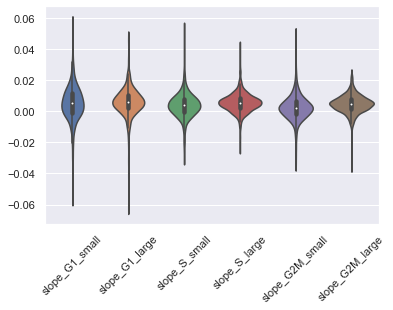

In [23]:
sns.violinplot(data=LRcs_df[['slope_G1_small', 'slope_G1_large', 'slope_S_small', 'slope_S_large', 'slope_G2M_small', 'slope_G2M_large']])
plt.xticks(rotation = 45)
plt.savefig('TEMPOmap-1000-old-dr_regression-cc-size.pdf')

In [ ]:
# cell cycle
LRcc = []
X = [0,1,2,4,6]
for gene in genes:
    if gene not in starmap_genes:
        y_G1 = df_cc_5[df_cc_5['gene']==gene]['avgDR_G1']
        y_S = df_cc_5[df_cc_5['gene']==gene]['avgDR_S']
        y_G2M = df_cc_5[df_cc_5['gene']==gene]['avgDR_G2M']
        r_G1 = linregress(X, y_G1)
        r_S = linregress(X, y_S)
        r_G2M = linregress(X, y_G2M)
        LRcc.append([gene, r_G1.slope, r_G1.rvalue**2, r_S.slope, r_S.rvalue**2, r_G2M.slope, r_G2M.rvalue**2])
LRcc_df = pd.DataFrame(LRcc, columns=['gene', 'slope_G1', 'r^2_G1', 'slope_S', 'r^2_S', 'slope_G2M', 'r^2_G2M'])
LRcc_df.to_excel('TEMPO-regression_cc.xlsx')
LRcc_df

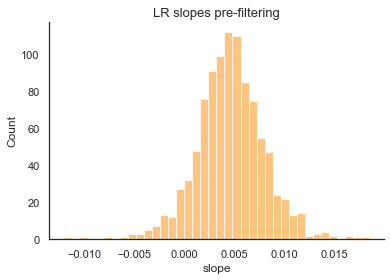

In [477]:
# plot slopes for all genes
sns.histplot(LR_df['slope'], color='darkorange', alpha=0.5)
plt.title('LR slopes pre-filtering', fontsize=13)
sns.despine()

(Text(0.5, 0, ''), None)

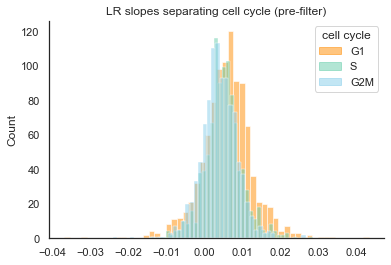

In [78]:
# slope cc
sns.set_theme(style='white'), sns.despine()
sns.histplot(LRcc_df['slope_G1'], color='darkorange', alpha=0.5)
sns.histplot(LRcc_df['slope_S'], color='mediumaquamarine', alpha=0.5)
sns.histplot(LRcc_df['slope_G2M'], color='skyblue', alpha=0.5)
G1_patch = mpatches.Patch(color='darkorange', label='G1', alpha=0.5)
S_patch = mpatches.Patch(color='mediumaquamarine', label='S', alpha=0.5)
G2M_patch = mpatches.Patch(color='skyblue', label='G2M', alpha=0.5)
plt.legend(title='cell cycle', handles=[G1_patch, S_patch, G2M_patch])
plt.title('LR slopes separating cell cycle (pre-filter)')
plt.xlabel(None), sns.despine()

(Text(0.5, 1.0, 'r^2 values'), None)

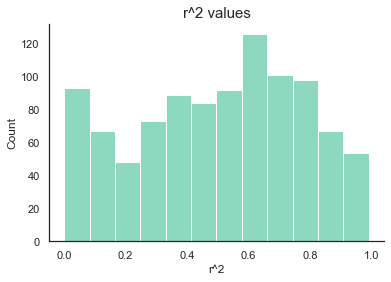

In [44]:
# plot coefficients and set threshold
sns.histplot(LR_df['r^2'], color='mediumaquamarine')
plt.title('r^2 values', fontsize=15), sns.despine()

(Text(0.5, 0, ''), None)

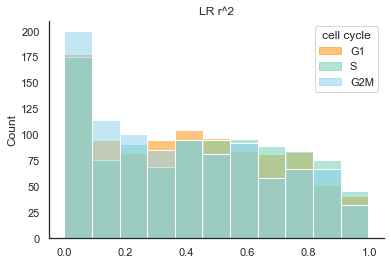

In [80]:
# r value cc
sns.histplot(LRcc_df['r^2_G1'], color='darkorange', alpha=0.5)
sns.histplot(LRcc_df['r^2_S'], color='mediumaquamarine', alpha=0.5)
sns.histplot(LRcc_df['r^2_G2M'], color='skyblue', alpha=0.5)
G1_patch = mpatches.Patch(color='darkorange', label='G1', alpha=0.5)
S_patch = mpatches.Patch(color='mediumaquamarine', label='S', alpha=0.5)
G2M_patch = mpatches.Patch(color='skyblue', label='G2M', alpha=0.5)
plt.legend(title='cell cycle', handles=[G1_patch, S_patch, G2M_patch])
plt.title('LR r^2')
plt.xlabel(None), sns.despine()

(<matplotlib.legend.Legend at 0x7fa4066b7eb0>, None)

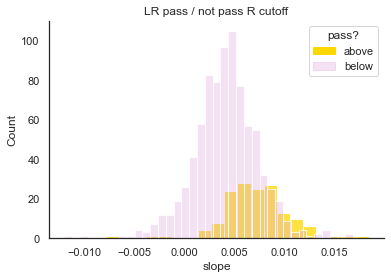

In [45]:
# plot slopes passing threshold
r_thres = 0.8
sns.histplot(LR_df['slope'][LR_df['r^2']>r_thres], color='gold')
sns.histplot(LR_df['slope'][LR_df['r^2']<=r_thres], color='plum', alpha=0.3)
plt.title('LR pass / not pass R cutoff')
pass_patch = mpatches.Patch(color='gold', label='above')
Npass_patch = mpatches.Patch(color='plum', label='below', alpha=0.3)
plt.legend(title='pass?', handles=[pass_patch, Npass_patch]), sns.despine()

(<matplotlib.legend.Legend at 0x7fa40820c100>, None)

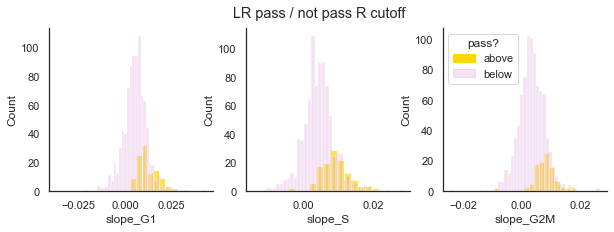

In [91]:
# plot slopes passing threshold
r_thres = 0.8
fig, ax = plt.subplots(1,3, figsize=(10,3))
sns.despine()
sns.histplot(LRcc_df['slope_G1'][LRcc_df['r^2_G1']>r_thres], color='gold', ax=ax[0])
sns.histplot(LRcc_df['slope_G1'][LRcc_df['r^2_G1']<=r_thres], color='plum', alpha=0.3, ax=ax[0])
sns.histplot(LRcc_df['slope_S'][LRcc_df['r^2_S']>r_thres], color='gold', ax=ax[1])
sns.histplot(LRcc_df['slope_S'][LRcc_df['r^2_S']<=r_thres], color='plum', alpha=0.3, ax=ax[1])
sns.histplot(LRcc_df['slope_G2M'][LRcc_df['r^2_G2M']>r_thres], color='gold', ax=ax[2])
sns.histplot(LRcc_df['slope_G2M'][LRcc_df['r^2_G2M']<=r_thres], color='plum', alpha=0.3, ax=ax[2])
fig.suptitle('LR pass / not pass R cutoff')
pass_patch = mpatches.Patch(color='gold', label='above')
Npass_patch = mpatches.Patch(color='plum', label='below', alpha=0.3)
plt.legend(title='pass?', handles=[pass_patch, Npass_patch]), sns.despine()

In [46]:
# visualize several standout cases
slope_thres = [0.012, 0.003]
# LR_df[np.logical_and(LR_df['r']>r_thres, LR_df['slope']>slope_thres)]
standout_genes_1 = LR_df[np.logical_and(LR_df['r^2']>r_thres, LR_df['slope']>slope_thres[0])]['gene']
standout_genes_2 = LR_df[np.logical_and(LR_df['r^2']>r_thres, LR_df['slope']<slope_thres[1])]['gene']
print(f'{list(standout_genes_1)}\n{list(standout_genes_2)}')

['GDF11', 'KIF13A', 'KIF3B', 'RREB1', 'SETD2', 'XRCC2', 'ZBTB5']
['BCOR', 'CANX', 'CHST15', 'NOTCH2', 'PXDN', 'SLC16A3', 'TSPYL1', 'ZNF207']


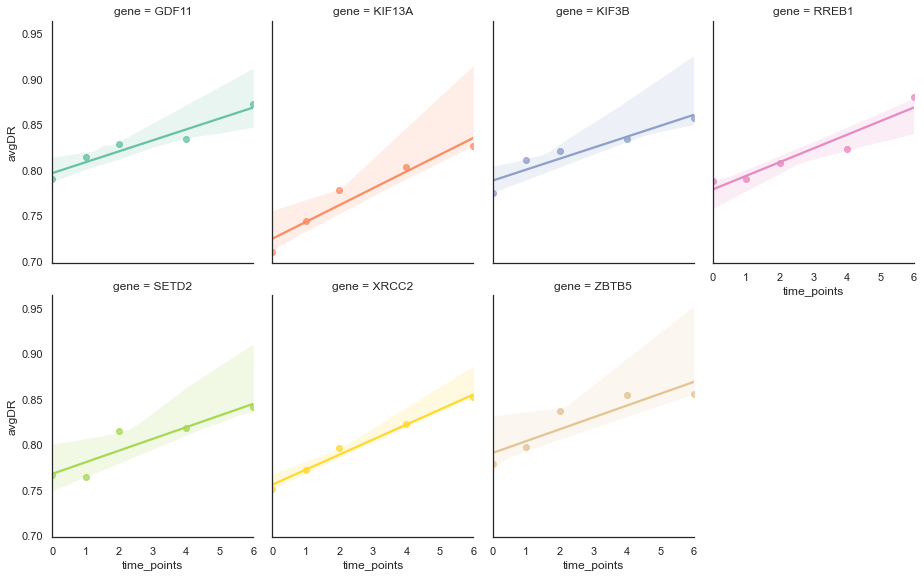

In [51]:
sns.set_theme(style='white')
sns.lmplot(data=df_sns_5[np.isin(df_sns_5['gene'], standout_genes_1)], x='time_points', y='avgDR', 
            hue='gene', col='gene', height=4, col_wrap=4, aspect=.8, palette='Set2')

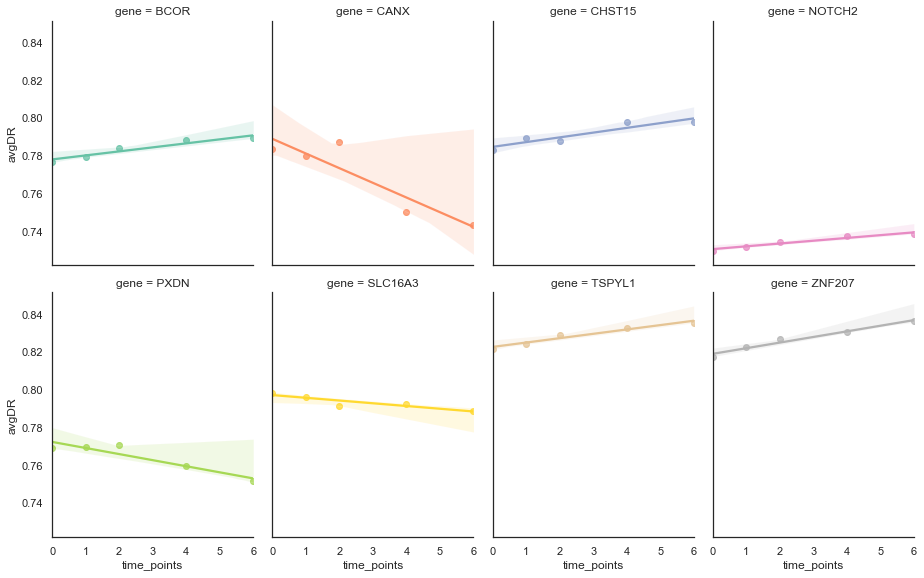

In [52]:
sns.lmplot(data=df_sns_5[np.isin(df_sns_5['gene'], standout_genes_2)], x='time_points', y='avgDR', 
            hue='gene', col='gene', height=4, col_wrap=4, aspect=.8, palette='Set2')

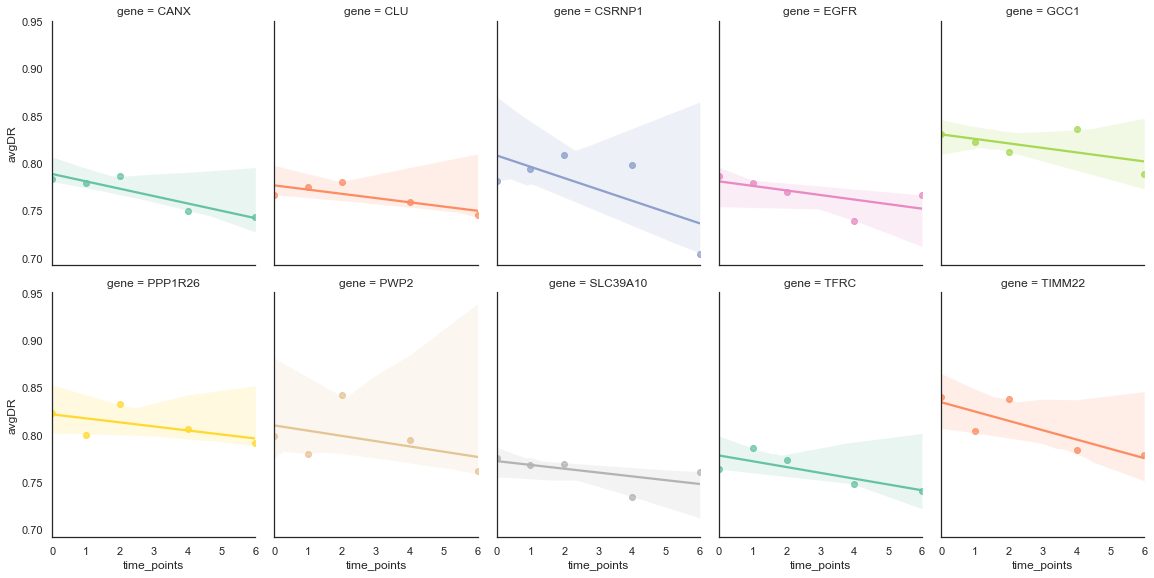

In [49]:
neg_slope_genes = LR_df[LR_df['slope']<-0.004]['gene']
sns.lmplot(data=df_sns_5[np.isin(df_sns_5['gene'], neg_slope_genes)], x='time_points', y='avgDR', 
            hue='gene', col='gene', height=4, col_wrap=5, aspect=.8, palette='Set2')

(<AxesSubplot:title={'center':'max diff in slopes between cc'}, ylabel='Count'>,
 Text(0.5, 1.0, 'max diff in slopes between cc'))

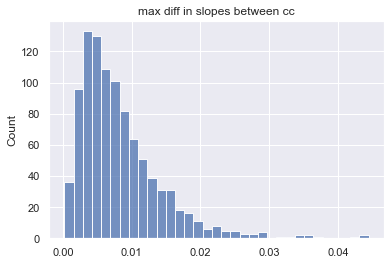

In [108]:
# genes whose slopes differ between cell cycles
diff_max = []
for i in range(LRcc_df.shape[0]):
    diff_max.append(max(abs(LRcc_df.iloc[i]['slope_G1'] - LRcc_df.iloc[i]['slope_S']),
                        abs(LRcc_df.iloc[i]['slope_G1'] - LRcc_df.iloc[i]['slope_G2M']),
                        abs(LRcc_df.iloc[i]['slope_G2M'] - LRcc_df.iloc[i]['slope_S'])))
sns.histplot(diff_max), plt.title('max diff in slopes between cc')

In [119]:
max_diff = pd.DataFrame(zip(LRcc_df['gene'], diff_max), columns=['gene', 'max_diff'])

In [120]:
sig_diff_genes = max_diff[max_diff['max_diff'] > 0.03]
sig_diff_genes

,gene,max_diff
12,LYPLA2,0.036202
214,CSTF3,0.044465
678,PWP2,0.037139
759,SLC25A25,0.034950
793,SOGA1,0.031771
847,TIMM22,0.043652
872,TPX2,0.035214
914,UNG,0.033215
924,VCL,0.034381
971,ZNF3,0.042314


In [145]:
df_cc_sns

,gene,avgDR,time_points,cc
0,YTHDC1,0.808518,0,avgDR_G1
1,AARS,0.806723,0,avgDR_G1
2,ASXL1,0.774168,0,avgDR_G1
3,COX7B,0.847429,0,avgDR_G1
4,CTGF,0.662066,0,avgDR_G1
...,...,...,...,...
987,ZRANB1,0.846654,6,avgDR_G2M
988,ZSCAN12,0.868834,6,avgDR_G2M
989,ZSCAN29,0.798792,6,avgDR_G2M
990,ZXDC,0.824874,6,avgDR_G2M


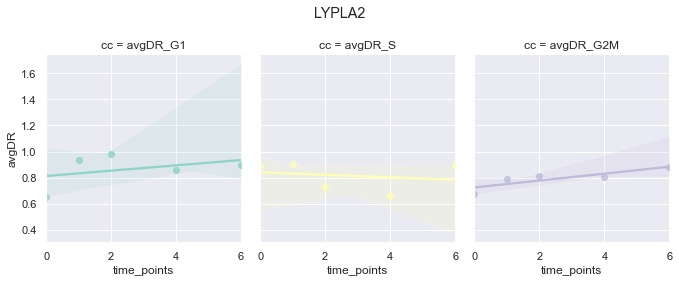

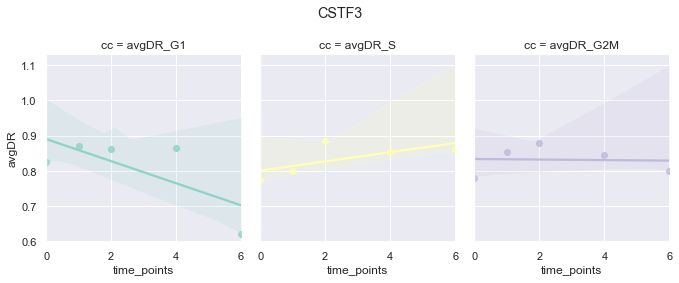

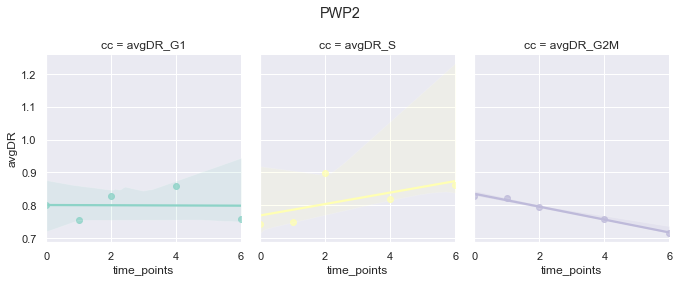

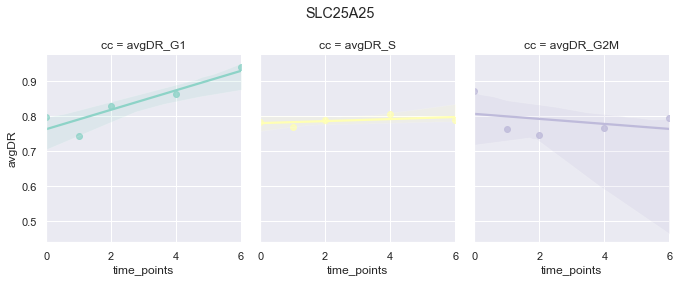

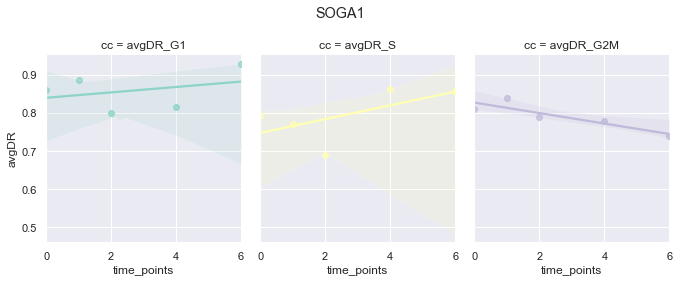

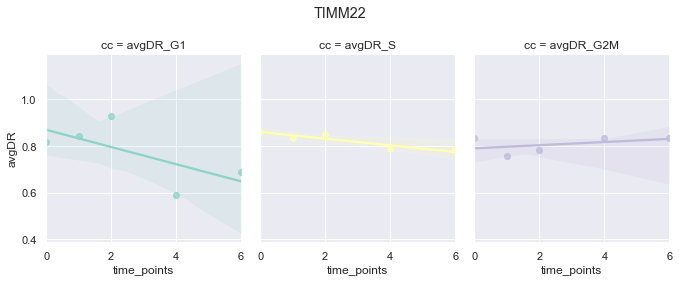

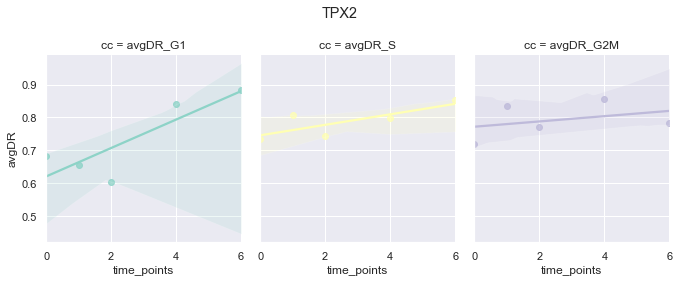

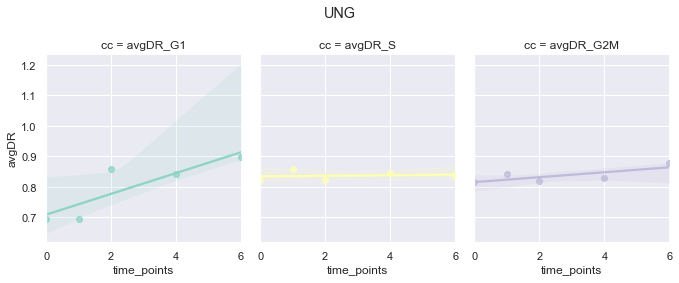

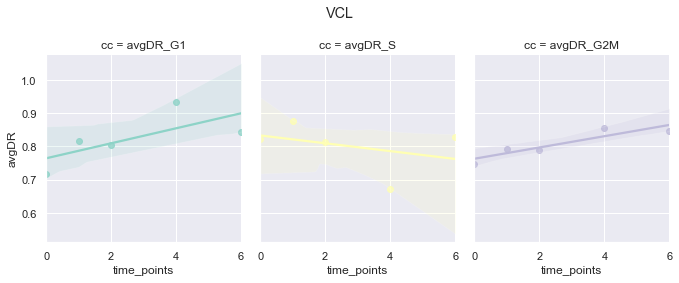

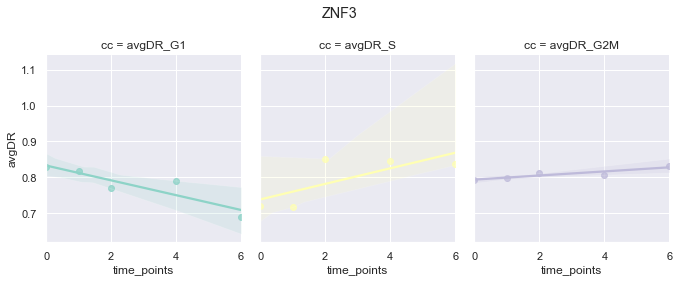

In [153]:
sns.set_theme()
for i, g in enumerate(sig_diff_genes['gene']):
    sns.lmplot(data=df_cc_sns[df_cc_sns['gene']==g], x='time_points', y='avgDR', hue='cc', col='cc', palette='Set3', height=4, aspect=0.8)
    plt.suptitle(g), plt.tight_layout()

Text(0.5, 1.0, 'ZNF3')

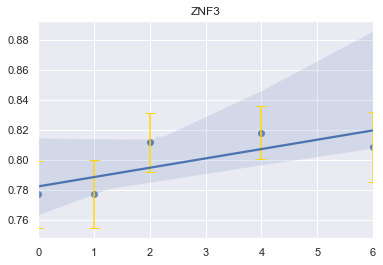

In [175]:
# with error bar (stdev)
test='ZNF3'
err = [sem(avg_DR[sample].layers['avg_DR'][avg_DR[sample].obs['KD_label_combined']=='siControl', genesToIndex[test]], nan_policy='omit') for sample in sample_list[:5]]
y = [np.nanmean(avg_DR[sample].layers['avg_DR'][avg_DR[sample].obs['KD_label_combined']=='siControl', genesToIndex[test]]) for sample in sample_list[:5]]
# sns.lmplot(data=df_sns_5[df_sns_5['gene']==test], x='time_points', y='avgDR', height=3, aspect=1)
fig, ax = plt.subplots()
sns.regplot(x=X, y=y, ax=ax)
ax.errorbar(X, y, yerr=err, fmt='none', ecolor='gold', capsize=5)
plt.title(test)